# 🎯 Exclusive π⁰ Reconstruction — NPS Experiment (2023–2024)

## ✨ Physics Motivation

We aim to extract the **exclusive cross section** for the process:

$
e + p \rightarrow e' + \pi^0 + p'
$

in which:
- The scattered electron is detected in the **HMS**.
- The two photons from π⁰ decay (π⁰ → γγ) are detected in the **NPS**.
- We do **not detect the recoil proton**, so we will apply an **exclusive cut** based on the **missing mass = proton mass**.

---

## 📁 Data Summary

- **Experiment**: NPS run group (Sept 2023 – May 2024)
- **Input**: Skimmed ROOT files located at  
  `/lustre24/expphy/volatile/hallc/nps/singhav/ROOTfiles/pi0_skimmed/`
- **Event structure**: one electron in HMS and two neutral clusters in NPS


In [1]:
import uproot
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
from vector import array as vec_array

# Physical constants
M_PROTON = 0.938  # GeV
M_PION0  = 0.135  # GeV

# Optional: Style
plt.style.use("seaborn-v0_8-poster")


In [2]:
# Load skimmed data file
file_path = "/home/ubuntu/nps_analysis/pi0_analysis/data/nps_hms_coin_skimmed_4398.root"
tree = uproot.open(file_path)["T"]

# Load branches
branches = tree.arrays([
    "T.hms.hEDTM_tdcTimeRaw", "T.hms.hTRIG4_tdcTimeRaw", "H.cal.etot", "H.cal.etotnorm",
    "H.cal.etottracknorm", "H.cal.etrack", "H.cal.etracknorm",
    "H.cer.npeSum", "H.gtr.dp", "H.gtr.th", "H.gtr.ph", "H.gtr.y", "H.gtr.p", 
    "H.gtr.px", "H.gtr.py", "H.gtr.pz", "H.gtr.x", "H.gtr.y", "NPS.cal.nclust", "NPS.cal.clusE",
    "NPS.cal.clusX", "NPS.cal.clusY", "NPS.cal.clusT"
])

tree.keys()

['Ndata.NPS.cal.clusE',
 'NPS.cal.clusE',
 'Ndata.NPS.cal.clusT',
 'NPS.cal.clusT',
 'Ndata.NPS.cal.clusX',
 'NPS.cal.clusX',
 'Ndata.NPS.cal.clusY',
 'NPS.cal.clusY',
 'H.cal.etot',
 'H.cal.etotnorm',
 'H.cal.etottracknorm',
 'H.cal.etrack',
 'H.cal.etracknorm',
 'H.cer.npeSum',
 'H.gtr.dp',
 'H.gtr.p',
 'H.gtr.ph',
 'H.gtr.px',
 'H.gtr.py',
 'H.gtr.pz',
 'H.gtr.th',
 'H.gtr.x',
 'H.gtr.y',
 'NPS.cal.nclust',
 'T.hms.hEDTM_tdcTimeRaw',
 'T.hms.hTRIG1_tdcTimeRaw',
 'T.hms.hTRIG2_tdcTimeRaw',
 'T.hms.hTRIG3_tdcTimeRaw',
 'T.hms.hTRIG4_tdcTimeRaw',
 'T.hms.hTRIG5_tdcTimeRaw',
 'T.hms.hTRIG6_tdcTimeRaw']

# Opening Angle Calculation

The neutral pion decays via:

$$
\pi^0 \to \gamma\gamma
$$

Using four-momentum conservation:

$$
P_\pi^2 = (P_{\gamma_1} + P_{\gamma_2})^2
$$

Expanding the right-hand side:

$$
m_\pi^2 = P_{\gamma_1}^2 + P_{\gamma_2}^2 + 2P_{\gamma_1}^\mu P_{\gamma_2\mu}
$$

Since photons are massless, $ P_{\gamma_i}^2 = 0 $, so:

$$
m_\pi^2 = 2P_{\gamma_1}^\mu P_{\gamma_2\mu}
$$

Using the inner product of four-vectors:

$$
m_\pi^2 = 2 \left( E_{\gamma_1}E_{\gamma_2} - \vec{p}_{\gamma_1} \cdot \vec{p}_{\gamma_2} \right)
$$

The dot product can be written in terms of the opening angle $\theta$ between the two photons:

$$
\vec{p}_{\gamma_1} \cdot \vec{p}_{\gamma_2} = |\vec{p}_{\gamma_1}||\vec{p}_{\gamma_2}|\cos\theta
$$

Since $ |\vec{p}_{\gamma_i}| = E_{\gamma_i} $ for photons:

$$
m_\pi^2 = 2E_{\gamma_1}E_{\gamma_2}(1 - \cos\theta)
$$

Using the identity $( 1 - \cos\theta = 2\sin^2(\theta/2) )$, we get:

$$
m_\pi^2 = 4E_{\gamma_1}E_{\gamma_2} \sin^2(\theta/2)
$$

Solving for the opening angle $\theta$:

$$
\theta = 2 \sin^{-1}\left( \frac{m_\pi}{\sqrt{4E_{\gamma_1}E_{\gamma_2}}} \right)
$$

This relation can be used as a **kinematic constraint** to validate whether a photon pair is consistent with originating from a real $ \pi^0 $ decay.


In [5]:
# function to reconcstruct invariant neutral pion mass taking into account the opening angle

import numba as nb
import numpy as np
from tqdm import tqdm

M_PION0  = 0.135  # GeV

@nb.njit
def reconstruct_pi0_mass_fast_w_opening_angle(e1, e2, x1, y1, x2, y2, z_nps=407): # z_nps in cm
    r1 = np.array([x1, y1, z_nps])
    r2 = np.array([x2, y2, z_nps])
    norm1 = np.sqrt(np.sum(r1 ** 2))
    norm2 = np.sqrt(np.sum(r2 ** 2))
    u1 = r1 / norm1
    u2 = r2 / norm2
    p1 = e1 * u1
    p2 = e2 * u2
    total_E = e1 + e2
    total_p = p1 + p2

    # Opening angle cut
    theta_ideal = 2 * np.arcsin(M_PION0 / np.sqrt(4 * e1 * e2))
    dot = np.dot(u1, u2)
    dot = min(1.0, max(-1.0, dot))  # Clamp to avoid NaNs from rounding errors
    theta_data = np.arccos(dot)


    # block_dim = 0.0205 # 2.05 x 2.05 cm^2 PbWO4 scintillator block
    theta_tolerance_rad = 0.01 # considering a cluster size of 4x4 blocks and the distance of NPS of 4.07 m. theta = (4x0.0205)/nps_distance

    if np.abs(theta_data - theta_ideal) < theta_tolerance_rad:  # radians
        m2 = total_E**2 - np.dot(total_p, total_p)
        return np.sqrt(m2) if m2 > 0 else 0.0
    else:
        return 0.0  # Or np.nan if you prefer masking out

<>:20: SyntaxWarning: invalid escape sequence '\g'
<>:23: SyntaxWarning: invalid escape sequence '\p'
<>:20: SyntaxWarning: invalid escape sequence '\g'
<>:23: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_66270/2541243727.py:20: SyntaxWarning: invalid escape sequence '\g'
  plt.xlabel("Reconstructed $M_{\gamma\gamma}$ [GeV]")
/tmp/ipykernel_66270/2541243727.py:23: SyntaxWarning: invalid escape sequence '\p'
  plt.title("Reconstructed $\pi^0$ Mass from Two Photons")
Processing events: 100%|██████████| 3222394/3222394 [07:32<00:00, 7114.65it/s]


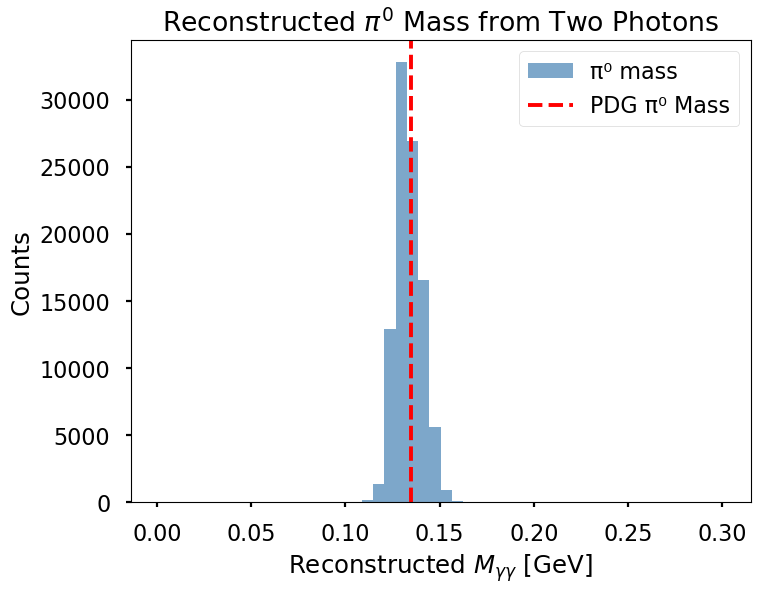

In [6]:
from tqdm import tqdm

masses = []
for event in tqdm(branches, desc="Processing events"):
    e = np.asarray(event["NPS.cal.clusE"])
    x = np.asarray(event["NPS.cal.clusX"])
    y = np.asarray(event["NPS.cal.clusY"])
    if len(e) < 2:
        continue
    idx = np.argsort(e)[-2:]
    masses.append(reconstruct_pi0_mass_fast_w_opening_angle(
        e[idx[0]], e[idx[1]],
        x[idx[0]], y[idx[0]],
        x[idx[1]], y[idx[1]]
    ))

plt.figure(figsize=(8,6))
plt.hist(masses, bins=50, range=(0.001, 0.3), color="steelblue", alpha=0.7, label="π⁰ mass")
plt.axvline(M_PION0, color='red', linestyle='--', label='PDG π⁰ Mass')
plt.xlabel("Reconstructed $M_{\gamma\gamma}$ [GeV]")
plt.ylabel("Counts")
plt.legend()
plt.title("Reconstructed $\pi^0$ Mass from Two Photons")
plt.show()

<>:16: SyntaxWarning: invalid escape sequence '\p'
<>:25: SyntaxWarning: invalid escape sequence '\p'
<>:28: SyntaxWarning: invalid escape sequence '\g'
<>:30: SyntaxWarning: invalid escape sequence '\p'
<>:16: SyntaxWarning: invalid escape sequence '\p'
<>:25: SyntaxWarning: invalid escape sequence '\p'
<>:28: SyntaxWarning: invalid escape sequence '\g'
<>:30: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_66270/2489511093.py:16: SyntaxWarning: invalid escape sequence '\p'
  density=True, color="steelblue", alpha=0.6, label="Reconstructed $\pi^0$ Mass"
/tmp/ipykernel_66270/2489511093.py:25: SyntaxWarning: invalid escape sequence '\p'
  plt.axvline(0.13498, color='red', linestyle='--', label='PDG $\pi^0$ Mass (134.98 MeV)')
/tmp/ipykernel_66270/2489511093.py:28: SyntaxWarning: invalid escape sequence '\g'
  plt.xlabel("Reconstructed $M_{\gamma\gamma}$ [GeV]", fontsize=14)
/tmp/ipykernel_66270/2489511093.py:30: SyntaxWarning: invalid escape sequence '\p'
  plt.title("Reconst

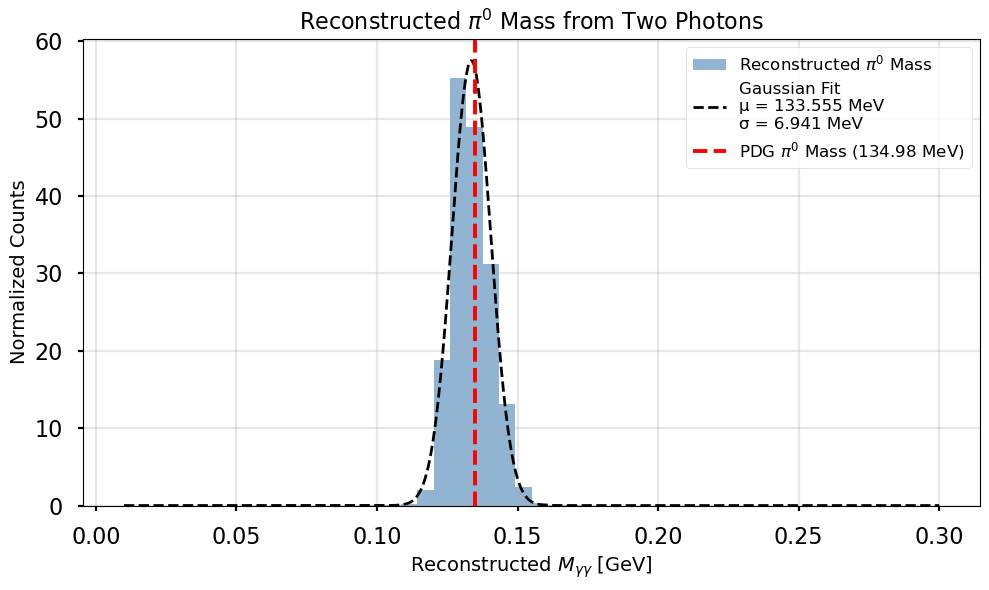

Fitted Mean: 0.1336 GeV
Fitted Std Dev: 0.0069 GeV


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Assuming `masses` is your array of reconstructed π⁰ masses
masses_clean = np.array(masses)
masses_clean = masses_clean[(masses_clean > 0.01) & (masses_clean < 0.3)]

# Fit a Gaussian
mu, std = norm.fit(masses_clean)

# Plot histogram
plt.figure(figsize=(10, 6))
counts, bins, _ = plt.hist(
    masses_clean, bins=50, range=(0.01, 0.3), 
    density=True, color="steelblue", alpha=0.6, label="Reconstructed $\pi^0$ Mass"
)

# Plot Gaussian fit
x = np.linspace(0.01, 0.3, 1000)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k--', linewidth=2, label=f'Gaussian Fit\nμ = {1000*mu:.3f} MeV\nσ = {1000*std:.3f} MeV')

# PDG mass line
plt.axvline(0.13498, color='red', linestyle='--', label='PDG $\pi^0$ Mass (134.98 MeV)')

# Labels and legend
plt.xlabel("Reconstructed $M_{\gamma\gamma}$ [GeV]", fontsize=14)
plt.ylabel("Normalized Counts", fontsize=14)
plt.title("Reconstructed $\pi^0$ Mass from Two Photons", fontsize=16)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Fitted Mean: {mu:.4f} GeV")
print(f"Fitted Std Dev: {std:.4f} GeV")


# 🧭 Coordinate Transformations in Hall C (Jefferson Lab)

This notebook uses a series of rotations to transform momentum vectors between coordinate systems used in Hall C:

## 🔁 Coordinate Systems

| System                  | Description                                                                 |
|------------------------|-----------------------------------------------------------------------------|
| **Hall (h)**           | Global frame:  
                         - \(+z_h\): along beam direction  
                         - \(+x_h\): beam-left  
                         - \(+y_h\): vertical up (ceiling) |
| **Spectrometer (s)**   | Aligned with spectrometer central ray:  
                         - \(+z_s\): along spectrometer axis (rotated by θ)  
                         - \(+x_s\): dispersive (toward floor)  
                         - \(+y_s\): non-dispersive (beam-left) |
| **Detector Hut (d)**   | Local detector frame:  
                         - Rotated from spectrometer frame by 25° about \(y_s\)  
                         - \(+z_d\): along dipole bend direction |

---

## 🔄 HMS Electron: Detector Hut → Hall Coordinates

For HMS (to right of beam), apply **inverse rotations**:

1. **Rotate +25° about y-axis**  
   → detector hut → spectrometer  
   `rotate_y(p_vec, 25)`

2. **Rotate +90° about z-axis**  
   → spectrometer → intermediate (undo -90°)  
   `rotate_z(p_spec, 90)`

3. **Rotate +θ about y-axis**  
   → undo spectrometer central angle (e.g., θ = 19.36°)  
   `rotate_y(p_spec, theta_deg)`

---

## 🔄 NPS Photon: Spectrometer → Hall Coordinates

For NPS (to left of beam), apply:

1. **Rotate +90° about z-axis**  
   → spectrometer → intermediate  
   `rotate_z(p_vec, 90)`

2. **Rotate −θ about y-axis**  
   → undo spectrometer angle (e.g., θ = 17.5°)  
   `rotate_y(p_spec, -theta_deg)`

---

## 🧮 Detector Hut Origin Offset

The origin of the detector hut system is **offset** from the Hall origin by distance **L** along the spectrometer axis:

```python
def detector_origin_in_hall(L, theta_deg):
    x = L * sin(θ)
    z = L * cos(θ)


In [ ]:
def rotate_x(vec, theta_deg):
    theta = np.radians(theta_deg)
    Rx = np.array([
        [1, 0, 0],
        [0, np.cos(theta), np.sin(theta)],
        [-np.sin(theta), 0, np.cos(theta)]
    ])
    return Rx @ vec

def rotate_y(vec, theta_deg): #/u/group/nps/apps/NPSlib/fddb8e9/src/src/THcNPSSecondaryKine.cxx
    theta = np.radians(theta_deg)
    Ry = np.array([
        [np.cos(theta), 0, np.sin(theta)],
        [0, 1, 0],
        [-np.sin(theta), 0, np.cos(theta)]
    ])
    return Ry @ vec

def rotate_z(vec, theta_deg):
    theta = np.radians(theta_deg)
    Rz = np.array([
        [np.cos(theta), np.sin(theta), 0],
        [-np.sin(theta), np.cos(theta), 0],
        [0, 0, 1]
    ])
    return Rz @ vec

def detector_hut_to_hall(px, py, pz, theta_deg):
    p_vec = np.array([px, py, pz])
    p_spec = rotate_z(p_vec, 90)
    p_spec = rotate_y(p_spec, theta_deg)

    return p_spec

def nps_to_hall(px, py, pz, theta_deg):
    p_vec = np.array([px, py, pz])
    # p_spec = rotate_z(p_vec, 90)
    # p_spec = rotate_y(p_spec, -theta_deg)
    p_spec = rotate_y(p_vec, -theta_deg)
    return p_spec



In [84]:
def pass_hms_cuts(edt, dp, etrnorm, npe, th, ph):
    cuts = (edt < 0.1 and abs(dp) < 8.5 and abs(etrnorm - 1) < 0.1 and 
            npe > 1.0 and abs(th) < 0.1 and abs(ph) < 0.05)
    return cuts

def is_good_cluster(e, t, x, y):
    cuts = (e > 0.5 and e < 1.0 and 148 <= t <= 152 and 
            29.16 < x < 29.16 and -35.64 < y < 35.64)

def get_photon_4vector(E, x, y, z_nps):
    r = np.array([x, y, z_nps])
    u = r/np.linalg.norm(r)
    p = E * u
    return np.array([E, *p])

def check_opening_angle(e1, e2, x1, y1, x2, y2, z_nps):
    r1 = np.array([x1, y1, z_nps])
    r2 = np.array([x2, y2, z_nps])
    u1 = r1 / np.linalg.norm(r1)
    u2 = r2 / np.linalg.norm(r2)

    s = 4 * e1 * e2
    arg = M_PION0 / np.sqrt(s)
    if abs(arg) > 1:
        return False
    else:
        theta_ideal = 2 * np.arcsin(arg)

    dot = np.dot(u1, u2)
    dot = min(1.0, max(-1, dot))
    theta_data = np.arccos(dot)

    theta_tolerance_rad = 0.02
    if np.abs(theta_ideal - theta_data) < theta_tolerance_rad:
        return 1

In [ ]:
import numpy as np
import awkward as ak
from tqdm import tqdm

m_e = 0.000511
m_p = 0.938
E_beam = 10.537
z_nps = 407 # cm

p4_ein = np.array([E_beam, 0, 0, E_beam]) # neglecting e- mass
p4_pin = np.array([m_p, 0, 0, 0])

has_two_clust = ak.num(branches["NPS.cal.clusE"]) >= 2

edt = ak.to_numpy(branches["T.hms.hEDTM_tdcTimeRaw"])[has_two_clust]
dp = ak.to_numpy(branches["H.gtr.dp"])[has_two_clust]
etrnorm = ak.to_numpy(branches["H.cal.etracknorm"])[has_two_clust]
npe = ak.to_numpy(branches["H.cer.npeSum"])[has_two_clust]
th = ak.to_numpy(branches["H.gtr.th"])[has_two_clust]
ph = ak.to_numpy(branches["H.gtr.ph"])[has_two_clust]
px_e = ak.to_numpy(branches["H.gtr.px"])[has_two_clust]
py_e = ak.to_numpy(branches["H.gtr.py"])[has_two_clust]
pz_e = ak.to_numpy(branches["H.gtr.pz"])[has_two_clust]
pe = ak.to_numpy(branches["H.gtr.p"])[has_two_clust] # taking e- E = e- p
Ee = ak.to_numpy(branches["H.gtr.p"])[has_two_clust]

clusE = branches["NPS.cal.clusE"][has_two_clust]
clusX = branches["NPS.cal.clusX"][has_two_clust]
clusY = branches["NPS.cal.clusY"][has_two_clust]
clusT = branches["NPS.cal.clusT"][has_two_clust]

missing_mass_sq = []

for i in tqdm(range(len(pe)), desc="Processing events"):

    pe_hall = detector_hut_to_hall(px_e[i], py_e[i], pz_e[i], theta_deg=19.36)
    p4_eout = np.array([Ee[i], *pe_hall])

    e_arr = np.array(clusE[i])
    x_arr = np.array(clusX[i])
    y_arr = np.array(clusY[i])
    t_arr = np.array(clusT[i])

    # Apply the energy cut: 0.5 < E < 1.0
    mask = (e_arr > 0.5) & (e_arr < 1.0)

    # Apply mask to all arrays
    e_arr = e_arr[mask]
    x_arr = x_arr[mask]
    y_arr = y_arr[mask]
    t_arr = t_arr[mask]

    if len(e_arr) < 2:
        continue
    idx = np.argsort(e_arr)[-2:]

    e1, e2 = e_arr[idx[1]], e_arr[idx[0]]
    x1, x2 = x_arr[idx[1]], x_arr[idx[0]]
    y1, y2 = y_arr[idx[1]], y_arr[idx[0]]
    t1, t2 = t_arr[idx[1]], t_arr[idx[0]]

    if not check_opening_angle(e1, e2, x1, y1, x2, y2, z_nps):
        continue

    if not pass_hms_cuts(edt[i], dp[i], etrnorm[i], npe[i], th[i], ph[i]):
        continue

    photon1 = get_photon_4vector(e1, x1, y1, z_nps)
    photon2 = get_photon_4vector(e2, x2, y2, z_nps)

    p4_ph1 = np.array([photon1[0], *nps_to_hall(photon1[1], photon1[2], photon1[3], theta_deg=17.51)])
    p4_ph2 = np.array([photon2[0], *nps_to_hall(photon2[1], photon2[2], photon2[3], theta_deg=17.51)])

    p4_pi = p4_ph1 + p4_ph2
    # p4_pi = photon1 + photon2

    p4_in = p4_ein + p4_pin
    p4_out = p4_eout + p4_pi

    p4_miss = p4_in - p4_out

    m2_miss = p4_miss[0]**2 - np.dot(p4_miss[1:], p4_miss[1:])

    # if m2_miss < -1:
    # #     temp1 = p4_pi[0]**2 - np.dot(p4_pi[1:], p4_pi[1:])
    # #     temp2 = p4_pin[0]**2 - np.dot(p4_pin[1:], p4_pin[1:])
    # #     temp3 = p4_ein[0]**2 - np.dot(p4_ein[1:], p4_ein[1:])
    # #     temp4 = p4_eout[0]**2 - np.dot(p4_eout[1:], p4_eout[1:])
    # #     print(f"incoming electron: {np.sqrt(temp3)}, incoming proton: {np.sqrt(temp2)}, scattered electron^2: {temp4}, pion: {np.sqrt(temp1)}")
    #     print(f"total in: {p4_ein + p4_pin}, square: {(p4_ein + p4_pin)[0]**2 - (p4_ein + p4_pin)[3]**2}")
    #     print(f"eout unrotated: {Ee[i], px_e[i], py_e[i], pz_e[i]}, square: {Ee[i]**2 - px_e[i]**2 - py_e[i]**2 - pz_e[i]**2}")
    #     print(f"eout 4vec: {p4_eout}, square: {p4_eout[0]**2 - p4_eout[1]**2 - p4_eout[2]**2 - p4_eout[3]**2}")
    #     print(f"pi 4vec:   {p4_pi}, square root: {np.sqrt(p4_pi[0]**2 - p4_pi[1]**2 - p4_pi[2]**2 - p4_pi[3]**2)}")
    #     print(f"total out: {p4_out}, square: {p4_out[0]**2 - p4_out[1]**2 - p4_out[2]**2 - p4_out[3]**2}")
    #     print(f"miss 4vec: {p4_miss}")
    #     print(f"m²_miss:   {m2_miss:.4f}")

    missing_mass_sq.append(m2_miss)



Processing events:   0%|          | 0/1867180 [00:00<?, ?it/s]/tmp/ipykernel_4490/1228960691.py:39: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  e_arr = np.array(clusE[i])
/tmp/ipykernel_4490/1228960691.py:40: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  x_arr = np.array(clusX[i])
/tmp/ipykernel_4490/1228960691.py:41: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keywor

KeyboardInterrupt: 

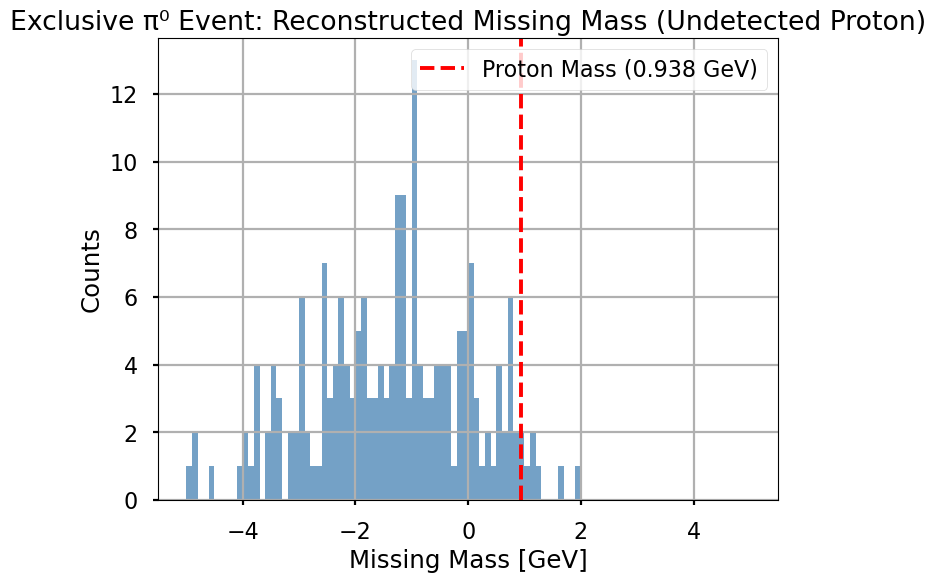

In [86]:
# Plot
plt.figure(figsize=(8,6))
plt.hist(missing_mass_sq, bins=100, range=(-5,5), color='steelblue', alpha=0.75)
plt.axvline(m_p, color='red', linestyle='--', label='Proton Mass (0.938 GeV)')
plt.xlabel("Missing Mass [GeV]")
plt.ylabel("Counts")
plt.title("Exclusive π⁰ Event: Reconstructed Missing Mass (Undetected Proton)")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
bins = np.linspace(-30, 30, 30)  # This gives [-30, 20]

plt.hist(clusX, bins=bins, edgecolor='black')
plt.xlabel("Cluster X (cm)")
plt.ylabel("Counts")
plt.title("Histogram of NPS Cluster X Position")
plt.grid(True)
plt.show()


ValueError: cannot convert to RegularArray because subarray lengths are not regular (in compiled code: https://github.com/scikit-hep/awkward/blob/awkward-cpp-46/awkward-cpp/src/cpu-kernels/awkward_ListOffsetArray_toRegularArray.cpp#L22)

In [54]:
clusE

<Array [[0.276, 0.62, 0.0756, 0.243], ...] type='1867180 * var * float64'>

In [29]:
clusX

array([-21.41504404, -19.57866181, -24.84      , ..., -24.84      ,
        16.15340521, -11.88      ], shape=(7607590,))